# Studying Put and Call options in the Wealth equation

In this notebook, we will cover the basic intuition behind European put/call options.

In [1]:
import numpy as np
from functools import wraps
from time import time
from scipy.special import binom
import matplotlib.pyplot as plt
from Binomial_asset_tree import *

# import jtplot submodule from jupyterthemes
from jupyterthemes import jtplot
jtplot.style()

# The European Call option

A European call option gives you (the owner of the contract) the right, but not the obligation to purchase an underlying stock $S$ at a given strike price $K$ at some later time $N$. This put option will come with a payoff (to you the owner) of $V_{N} = \max (S_{N} - K, 0)$, which means that if the stock is higher than the strike price $K$, you will pocket the difference. Note the zero corresponds to the case where you decide not to buy the underlying, hence it has no value. How do you pocket the difference? Well, you would buy the stock at price $K$ and then immediately sell it on the open market for $S_{N}$, therefore making $S_{N} - K$ (excluding fees of course)!

The Call option is typically used by someone who is bullish on the performance of the given underlying asset. Here we will construct a very simple model and try to understand the predictions made by the binomial asset model.

In [2]:
# Define some system parameters for the model N is number of steps, u is increase in price per step (if it goes up), K is strike price at N
u = 2
p = 0.5
N = 3
K = 3

# Start with the following parameters
params_call = {'S0': 4,
            'p' : p,
            'r': 0.25,
            'u': u,
            'd': 1/u,
            'K': K,
            'N': N,
            'T': 1,
            'option': 'call'}

# create random model
m_call = binomial_tree_european(params_call)

In this model, we can see that the initial stock price is $S0$, and the strike price is $K$. Given that we want to purchase a call option, then we are expecting that the stock price will go above the $K$ at time $N$. Let's first look at the final payoffs of this model

We can clearly see that some of the pay offs are zero (in the case when the stock price was below the strike price) and greater than zero when it was above the strike price. Using this model, and starting with these pay offs, we can compute the initial value of the put option at $V_{0}$ using the risk neutral pricing probability measure $\tilde{P}$ which in the binomial asset model are 
\begin{equation}
\tilde{p} = \frac{1 + r - d}{u - d}\quad \tilde{q} = 1- \tilde{p}\,,
\end{equation}
where $u, d, r$ are the up, down, multiplicative changes in the underlying at each time-step, and $r$ is the interest rate per unit time. These are derived under the no-arbitrage condition that $0<d<1+r<u$, so this would be a complete and efficient market. Now, let's study how does the initial price of $V_{0}$ as a function of the strike price $K$?

In [3]:
K = np.linspace(0, 100, 100)
V0 = np.zeros(len(K))
EVn = np.zeros(len(K))
d0 = np.zeros(len(K))

# Define some system parameters for the model N is number of steps, u is increase in price per step (if it goes up), K is strike price at N
u = 2
p = 0.5
N = 3
S0 = 10
r = 0.25

params_call = {'S0': S0,
            'p' : p,
            'r': r,
            'u': u,
            'd': 1/u,
            'N': N,
            'T': 1,
            'option': 'call'}

for i, Ki in enumerate(K):
    
    # Start with the following parameters
    params_call['K'] = Ki
    # Create model
    m_call = binomial_tree_european(params_call)
    
    # Compute initial value of 
    V0[i] = m_call.V0
    d0[i] = m_call.delta0


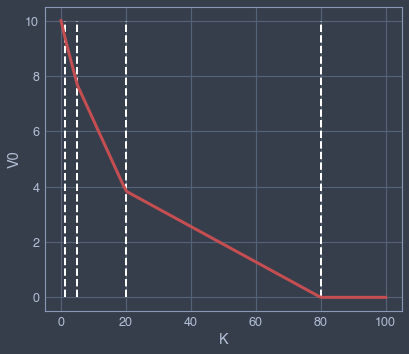

In [4]:
plt.plot(K, V0, color='r', linewidth=3)
plt.vlines(m_call.calculate_Sn(N), 0, 10, color='white', linestyle='--', linewidth=2)
plt.ylabel('V0')
plt.xlabel('K')

plt.show()

Here we can see that as the strike price increases, the price of the Call option at $n=0$ decreases. The white lines corresponds to the final underlying prices $S_{N}$ which show how the rate of change in $V_0$ changes as the number of payoff opportunties decrease. This makes complete sense; as the strike price goes up, the contract loses its worth since our ability to make profit decreases, thus the amount we would be willing to pay for such a contract also decreases.

### The Delta Hedging formula
We can now compute the delta hedging forumla 
\begin{equation}
\Delta_{n} = \frac{V_{n+1}(u) - V_{n+1}(d)}{S_{n+1}(u) - S_{n+1}(d)}\,,
\end{equation}
which tells us about how much stock of the underlying we should purchace to offset the downside risk of option. It is the ratio of the difference in the options values depending on the difference in the change of the underlying. 
We can compute the initial hedging position $\Delta_{0}$ corresponding to the amount of the underlying that we should purchase initially to hedge againts the changes in the value of the option. 

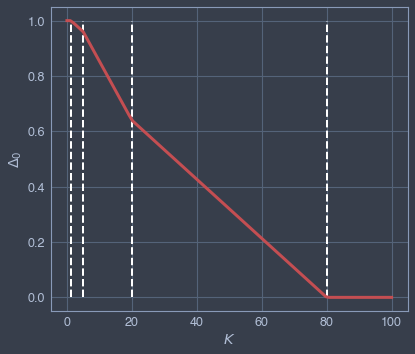

In [5]:
plt.plot(K, d0, color='r', linewidth=3)
plt.vlines(m_call.calculate_Sn(N), 0, 1, color='white', linestyle='--', linewidth=2)
plt.ylabel(r'$\Delta_{0}$')
plt.xlabel(r'$K$')

plt.show()

We can clearly see that as the strike price increases (also decreasing the value of the initial option), the amount of stock that we should acquire also diminishes. This reflects the fact that options price is becoming worthless and the amount we need to hedge against is minimal.

### Our initial Cash Position
The final thing we need to talk about is the initial cash position, which reflects how we should finance our initial bet. Based on the risk neutral pricing we can compute our initial cash position as
\begin{equation}
    X_{0} - S_{0}\Delta_{0}\,,
\end{equation}
where $X_{0}$ is our initial wealth, minus the amount of stock we need to purchase to hedge our option. We should choose $X_{0} = V_{0}$ as this condition will ensure that our position is optimally hedged.
We can now compute, as a function of the strike price $K$ 

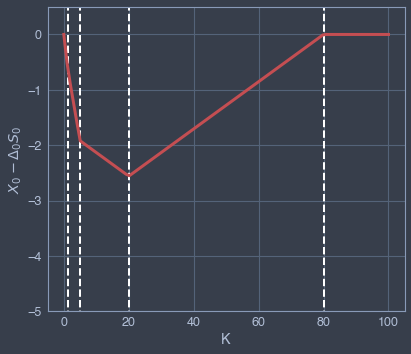

In [6]:
plt.plot(K, V0 - S0*d0, color='r', linewidth=3)
plt.vlines(m_call.calculate_Sn(N), -8, 8, color='white', linestyle='--', linewidth=2)
plt.ylabel(r'$X_{0} - \Delta_{0} S_{0}$')
plt.xlabel('K')

plt.ylim([-5,0.5])

plt.show()

As we can see, the initial cash position is negative for all $K>0$ and becomes equal to zero for $K>32$ corresponding to the point when there is no payoff. Firstly, the negative position tells us that our initial wealth $X_{0}$ corresponding to the initial value of the call option is less than the amount we need to cover the hedge $\Delta_{0}S_{0}$. Thus, we should borrow this money from the money market. As we will see when we study the dynamics of this, that this negative position will, over time become positive if the hedging is dynamically updated. Furthermore, there corresponds to a maximum amount that we should borrow coinciding with a strike price $K=K_{\rm ext}$. 

# European Put Options

Let's now repeat the same analysis but for European put options. 

A European put option gives you (the owner of the contract) the right, but not the obligation to sell an underlying stock $S$ at a given strike price $K$ at some later time $N$. This put option will come with a payoff (to you the owner) of $V_{N} = \max (K - S_{N}, 0)$, which means that if the stock is lower than the strike price $K$, you will pocket the difference. This means that you are bearish on the market and think the stock price will go down. Note the zero corresponds to the case where you decide not to sell the underlying, hence it has no payoff. How do you pocket the difference? Well, you would sell the stock at price $K$ leaving you with the difference (excluding fees of course)! If you wanted to, you could then buy back the far more of the stock if you wanted to.

In [10]:
K = np.linspace(0, 100, 100)
V0_put = np.zeros(len(K))
d0_put = np.zeros(len(K))

# Define some system parameters for the model N is number of steps, u is increase in price per step (if it goes up), K is strike price at N
params_call = {'S0': S0,
            'p' : p,
            'r': r,
            'u': u,
            'd': 1/u,
            'N': N,
            'T': 1,
            'option': 'put'}

for i, Ki in enumerate(K):
    
    # Start with the following parameters
    params_call['K'] = Ki
    # Create model
    m_put = binomial_tree_european(params_call)
    
    # Compute initial value of 
    V0_put[i] = m_put.V0
    d0_put[i] = m_put.delta0


First thing, we will study the change in the price of $V_{0}$ as a funcition of strike price.

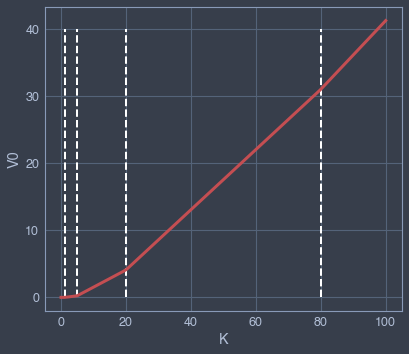

In [11]:
plt.plot(K, V0_put, color='r', linewidth=3)
plt.vlines(m_put.calculate_Sn(N), 0, 40, color='white', linestyle='--', linewidth=2)
plt.ylabel('V0')
plt.xlabel('K')

plt.show()

We see that as the strike price increases, so to does the value of the put option. This indicates the fact that we would be willing to pay a higher price for this derivative for higher strike since we expect the payoff to be larger. Again, the white lines corresponds to the final underlying prices $S_{N}$ which show how the rate of change in $V_0$ changes as the number of payoff opportunties decrease. 
This makes complete sense; as the strike price goes up, the contract increses in value since our ability to make profit increases.

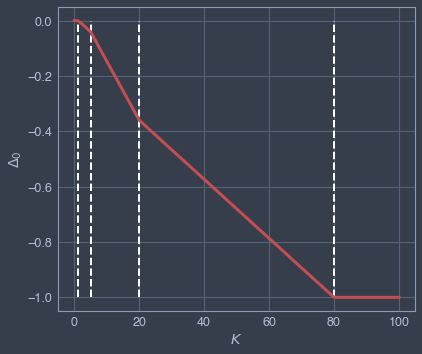

In [9]:
plt.plot(K, d0_put, color='r', linewidth=3)
plt.vlines(m_call.calculate_Sn(N), -1, 0, color='white', linestyle='--', linewidth=2)
plt.ylabel(r'$\Delta_{0}$')
plt.xlabel(r'$K$')

plt.show()

Next we plot the amount of stock we should hold $\Delta_{0}$ to hedge the bet. We see that this is negative (which reflects how we should finance this hedge). In anycase, the magnitude is what we care about here. When this is equal to negative 1, it tells us that the option value changes in lock step with that of stock (i.e the change in value between them is equal). 

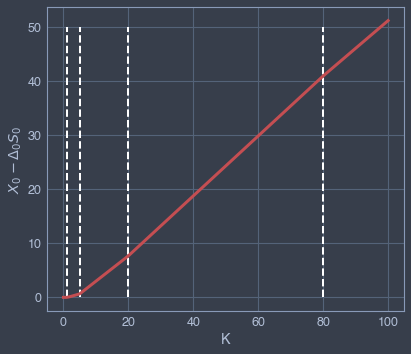

In [20]:
plt.plot(K, V0_put - S0*d0_put, color='r', linewidth=3)
plt.vlines(m_put.calculate_Sn(N), 0, 50, color='white', linestyle='--', linewidth=2)
plt.ylabel(r'$X_{0} - \Delta_{0} S_{0}$')
plt.xlabel('K')


plt.show()